In [13]:

import matplotlib.pyplot as plt
import numpy as np

# Qiskit関連のパッケージをインポート
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
#from qiskit.quantum_info import Statevector
#from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.accounts import AccountNotFoundError
from qiskit.primitives import StatevectorSampler


# ワークブック独自のモジュール
#from qc_workbook.utils import operational_backend

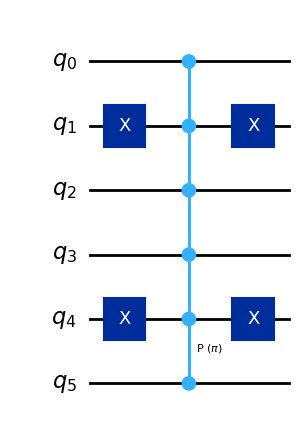

In [14]:
Nsol = 45
n_qubits = 6

grover_circuit = QuantumCircuit(n_qubits)

grover_circuit.h(range(n_qubits))
grover_circuit.barrier()

# オラクルを作成して、回路に実装
oracle = QuantumCircuit(n_qubits)

##################
### EDIT BELOW ###
##################
oracle.x(1)
oracle.x(4)
oracle.mcp(np.pi, list(range(n_qubits-1)), n_qubits-1)
oracle.x(1)
oracle.x(4)
##################
### EDIT ABOVE ###
##################

oracle_gate = oracle.to_gate()
oracle_gate.name = "U_w"
oracle.draw('mpl')

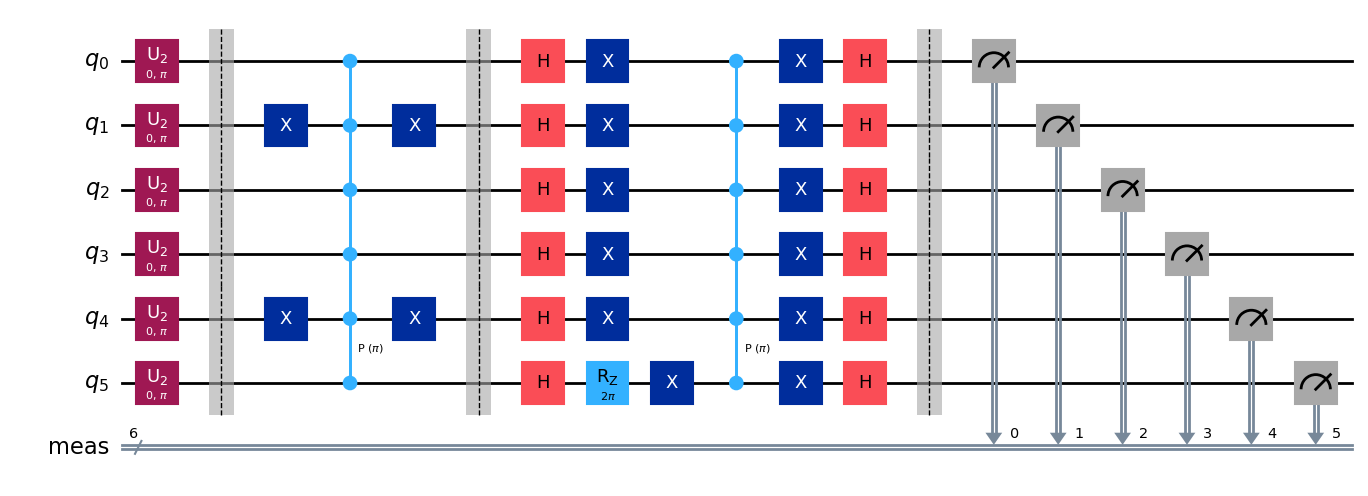

In [15]:
def diffuser(n):
    qc = QuantumCircuit(n)

    qc.h(range(n))

    ##################
    ### EDIT BELOW ###
    ##################

    qc.rz(2*np.pi, n-1)
    qc.x(list(range(n)))

    # multi-controlled Zゲート
    qc.mcp(np.pi, list(range(n-1)), n-1)

    qc.x(list(range(n)))

    ##################
    ### EDIT ABOVE ###
    ##################

    qc.h(range(n))

    #print(qc)
    U_s = qc.to_gate()
    U_s.name = "U_s"
    return U_s
grover_circuit.append(oracle_gate, list(range(n_qubits)))
grover_circuit.barrier()
grover_circuit.append(diffuser(n_qubits), list(range(n_qubits)))
grover_circuit.measure_all()
grover_circuit.decompose().draw('mpl')

シミュレータでの実験

In [16]:
# Instantiate new AerSimulator and Sampler objects
simulator = AerSimulator()
sampler = StatevectorSampler()

# Now run the job and examine the results
grover_circuit = transpile(grover_circuit, backend=simulator)
sampler_job = sampler.run(grover_circuit, shots=10000)
result = sampler_job.result()

from qiskit.visualization import plot_distribution
#plt.style.use('dark_background')
plot_distribution(result.quasi_dists[0])

'''
simulator = AerSimulator()
grover_circuit = transpile(grover_circuit, backend=simulator)
results = simulator.run(grover_circuit, shots=1024).result()
answer = results.get_counts()

# 横軸を整数でプロットする
def show_distribution(answer):
    n = len(answer)
    x = [int(key,2) for key in list(answer.keys())]
    y = list(answer.values())

    fig, ax = plt.subplots()
    rect = ax.bar(x,y)

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.3f}'.format(height/sum(y)),
                        xy=(rect.get_x()+rect.get_width()/2, height),xytext=(0,0),
                        textcoords="offset points",ha='center', va='bottom')
    autolabel(rect)
    plt.ylabel('Probabilities')
    plt.show()

show_distribution(answer)
'''

ValueError: An invalid Sampler pub-like was given (<class 'qiskit._accelerate.circuit.CircuitInstruction'>). If you want to run a single circuit, you need to wrap it with `[]` like `sampler.run([circuit])` instead of `sampler.run(circuit)`.

量子コンピュータでの実験


In [ ]:
# 利用できるインスタンスが複数ある場合（Premium accessなど）はここで指定する
# instance = 'hub-x/group-y/project-z'
instance = None

try:
    service = QiskitRuntimeService(channel='ibm_quantum', instance=instance)
except AccountNotFoundError:
    service = QiskitRuntimeService(channel='ibm_quantum', token='__paste_your_token_here__', instance=instance)

# 現在稼働中のバックエンド（実機）の中から一番空いているものを選ぶ
backend = service.least_busy(min_num_qubits=n_qubits, simulator=False, operational=True)
print(f"least busy backend: {backend.name}")

In [ ]:
# 最も空いているバックエンドで回路を実行します。
grover_circuit = transpile(grover_circuit, backend=backend, optimization_level=3)

session = Session(service=service, backend=backend)
sampler = RuntimeSampler(session=session)

job = sampler.run(qc)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Session ID: {job.session_id}")
print(f">>> Job Status: {job.status()}")
#job = backend.run(grover_circuit, shots=1024)

In [ ]:
# 計算結果
result = job.result()
plot_distribution(result.quasi_dists[0])

振幅増幅を確認する

In [ ]:
# 繰り返しの回数
Niter = 3

grover_circuit_iterN = QuantumCircuit(n_qubits)
grover_circuit_iterN.h(range(n_qubits))
for I in range(Niter):
    grover_circuit_iterN.append(oracle_gate, list(range(n_qubits)))
    grover_circuit_iterN.append(diffuser(n_qubits), list(range(n_qubits)))
grover_circuit_iterN.measure_all()
grover_circuit_iterN.draw('mpl')

In [ ]:
grover_circuit_iterN = transpile(grover_circuit_iterN, backend=simulator)
sampler_job = sampler.run(grover_circuit_iterN, shots=10000)
result = sampler_job.result()
plot_distribution(result.quasi_dists[0])
#grover_circuit_iterN_tr = transpile(grover_circuit_iterN, backend=simulator)
#results = simulator.run(grover_circuit_iterN_tr, shots=1024).result()
#answer = results.get_counts()
#show_distribution(answer)

In [ ]:
simulator = AerSimulator()
sampler = StatevectorSampler()

x = []
y = []

shots = 10000

# 例えば10回繰り返す
for Niter in range(1,11):
    grover_circuit_iterN = QuantumCircuit(n_qubits)
    grover_circuit_iterN.h(range(n_qubits))
    for I in range(Niter):
        grover_circuit_iterN.append(oracle_gate, list(range(n_qubits)))
        grover_circuit_iterN.append(diffuser(n_qubits), list(range(n_qubits)))
    grover_circuit_iterN.measure_all()

    grover_circuit_iterN = transpile(grover_circuit_iterN, backend=simulator)
    sampler_job_iterN = sampler.run(grover_circuit_iterN, shots=shots)
    results_sim_iterN = sampler_job_iterN.result()
    #grover_circuit_iterN_tr = transpile(grover_circuit_iterN, backend=simulator)
    #results = simulator.run(grover_circuit_iterN_tr, shots=1024).result()
    #answer = results.get_counts()

    x.append(Niter)
    y.append(results_sim_iterN.quasi_dists[0][Nsol]*shots)
    #y.append(answer[format(Nsol,'b').zfill(n)])

plt.clf()
plt.scatter(x,y)
plt.xlabel('N_iterations')
plt.ylabel('# of correct observations (1 solution)')
plt.show()

複数解の探索の場合

In [ ]:
N1 = 45
N2 = 26

# 45
oracle_2sol_1 = QuantumCircuit(n_qubits)
oracle_2sol_1.x(1)
oracle_2sol_1.x(4)
oracle_2sol_1.mcp(np.pi, list(range(n_qubits-1)), n_qubits-1)
oracle_2sol_1.x(1)
oracle_2sol_1.x(4)

# 26
oracle_2sol_2 = QuantumCircuit(n_qubits)
oracle_2sol_2.x(0)
oracle_2sol_2.x(2)
oracle_2sol_2.x(5)
oracle_2sol_2.mcp(np.pi, list(range(n_qubits-1)), n_qubits-1)
oracle_2sol_2.x(0)
oracle_2sol_2.x(2)
oracle_2sol_2.x(5)

oracle_2sol_gate = QuantumCircuit(n_qubits)
oracle_2sol_gate.append(oracle_2sol_1.to_gate(), list(range(n_qubits)))
oracle_2sol_gate.barrier()
oracle_2sol_gate.append(oracle_2sol_2.to_gate(), list(range(n_qubits)))
oracle_2sol_gate.barrier()
oracle_2sol_gate.name = "U_w(2sol)"
oracle_2sol_gate.decompose().draw('mpl')

oracle_2sol_gate = oracle_2sol.to_gate()
oracle_2sol_gate.name = "U_w(2sol)"
print(oracle_2sol)

In [ ]:
x = []
y = []
for Niter in range(1,11):
    grover_circuit_2sol_iterN = QuantumCircuit(n_qubits)
    grover_circuit_2sol_iterN.h(range(n_qubits))
    for I in range(Niter):
        grover_circuit_2sol_iterN.append(oracle_2sol_gate, list(range(n_qubits)))
        grover_circuit_2sol_iterN.append(diffuser(n_qubits), list(range(n_qubits)))
    grover_circuit_2sol_iterN.measure_all()
    #print('-----  Niter =',Niter,' -----------')
    #print(grover_circuit_2sol_iterN)

    grover_circuit_2sol_iterN = transpile(grover_circuit_2sol_iterN, backend=simulator)
    sampler_job_2sol_iterN = sampler.run(grover_circuit_2sol_iterN, shots=shots)
    results_sim_2sol_iterN = sampler_job_2sol_iterN.result()
    #grover_circuit_2sol_iterN_tr = transpile(grover_circuit_2sol_iterN, backend=simulator)
    #results = simulator.run(grover_circuit_2sol_iterN_tr, shots=1024).result()
    #nswer = results.get_counts()

    x.append(Niter)
    y.append((results_sim_2sol_iterN.quasi_dists[0][N1]+results_sim_2sol_iterN.quasi_dists[0][N2])*shots)
    #y.append(answer[format(N1,'06b')]+answer[format(N2,'06b')])

plt.clf()
plt.scatter(x,y)
plt.xlabel('N_iterations')
plt.ylabel('# of correct observations (2 solutions)')
plt.show()